In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.10.0+cpu
CUDA available: False


### Second Part: UL Data Loading and Pre-processing

The dataset is loaded from a pre-cleaned CSV file. Only two core system-level features are used as model inputs:
- `airtime`
- `selected_mcs`

The target variable is `pm_power`, representing power consumption.


In [ ]:
# ============================================================
# CELL 1 — Data Preparation & Group-wise Splitting
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# ------------------------------------------------------------
# 1) Load dataset
# ------------------------------------------------------------
# This dataset already includes UL samples with fixed conditions
# (traffic_load, BW, nRBs, clockspeed)
df = pd.read_csv("clean_ul_with_conditions2.csv")


# ------------------------------------------------------------
# 2) Define feature sets
# Each experiment isolates one key variable while keeping
# system parameters as additional inputs.
# ------------------------------------------------------------
FEATURE_SETS = {
    "gain":   ["txgain","traffic_load", "BW", "nRBs", "clockspeed"],
    "mcs":    ["selected_mcs","traffic_load", "BW", "nRBs", "clockspeed"],
    "airtime":["airtime", "traffic_load", "BW", "nRBs", "clockspeed"],
}

target_col = "pm_power"


# ------------------------------------------------------------
# 3) Numeric cleaning function
# Ensures:
#   - No missing values
#   - All columns numeric
#   - Target strictly positive (for MRE stability)
# ------------------------------------------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d.dropna(subset=cols_needed).copy()

    # Ensure target positive (avoids division instability in MRE)
    d = d[d[target_col] > 0].copy()

    return d


# ------------------------------------------------------------
# 4) Group-wise split
# For each unique value of group_col:
#   - 80% train
#   - 20% test
#   - Within train: 10% validation
#
# This ensures each parameter value appears in all sets.
# ------------------------------------------------------------
def groupwise_split_df(
    d,
    group_col,
    train_ratio=0.8,
    val_ratio_within_train=0.1,
    seed=42,
    min_group_size=5
):
    train_parts, val_parts, test_parts = [], [], []
    d2 = d.dropna(subset=[group_col]).copy()

    for gval, gdf in d2.groupby(group_col):

        # Skip very small groups
        if len(gdf) < min_group_size:
            continue

        # 80% train / 20% test
        g_train, g_test = train_test_split(
            gdf,
            test_size=(1 - train_ratio),
            random_state=seed
        )

        # Split validation from training portion
        g_train, g_val = train_test_split(
            g_train,
            test_size=val_ratio_within_train,
            random_state=seed
        )

        train_parts.append(g_train)
        val_parts.append(g_val)
        test_parts.append(g_test)

    if len(train_parts) == 0:
        raise ValueError(
            f"No groups large enough after grouping by '{group_col}'. "
            f"Try reducing min_group_size."
        )

    train_df = pd.concat(train_parts, ignore_index=True)
    val_df   = pd.concat(val_parts,   ignore_index=True)
    test_df  = pd.concat(test_parts,  ignore_index=True)

    return train_df, val_df, test_df


In [48]:
# ============================================================
# CELL 2 — Model Definition, Training, Evaluation
# ============================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ------------------------------------------------------------
# 1) Dataset wrapper for PyTorch
# ------------------------------------------------------------
class TabularDataset(Dataset):
    """
    Simple PyTorch Dataset for tabular regression.
    """
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------
# 2) Baseline DNN (Model 1)
# 3 hidden layers: 64 → 64 → 32
# ------------------------------------------------------------
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3) Mean Relative Error (percentage)
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(
        np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100
    )


# ------------------------------------------------------------
# 4) Training & Evaluation Function
# ------------------------------------------------------------
def train_eval_model1(
    train_df,
    val_df,
    test_df,
    feature_cols,
    target_col,
    epochs=100,
    batch_size=64,
    lr=1e-3,
    seed=42,
    verbose_every=10
):

    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extract arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # --------------------------------------------------------
    # Standardization (fit ONLY on training set)
    # --------------------------------------------------------
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # DataLoaders
    train_loader = DataLoader(
        TabularDataset(X_train_s, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        TabularDataset(X_val_s, y_val),
        batch_size=batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        TabularDataset(X_test_s, y_test),
        batch_size=batch_size,
        shuffle=False
    )

    # Model initialization
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BaselineDNN(in_dim=len(feature_cols)).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None

    print(f"\n[Model1] Training | features={feature_cols}")
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")

    # --------------------------------------------------------
    # Training loop
    # --------------------------------------------------------
    for epoch in range(1, epochs + 1):

        # ---- Training phase ----
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(xb)

        train_loss /= len(train_loader.dataset)

        # ---- Validation phase ----
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * len(xb)

        val_loss /= len(val_loader.dataset)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {
                k: v.detach().cpu().clone()
                for k, v in model.state_dict().items()
            }

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train MSE {train_loss:.6f} | "
                  f"Val MSE {val_loss:.6f}")

    # Load best weights
    model.load_state_dict(best_state)
    print("Best validation MSE:", best_val_loss)

    # --------------------------------------------------------
    # Test evaluation
    # --------------------------------------------------------
    model.eval()
    y_true_list, y_pred_list = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().reshape(-1)

            y_pred_list.append(pred)
            y_true_list.append(yb.numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mre_pct": mre,
        "y_true": y_true,
        "y_pred": y_pred,
        "model":model,
        "scaler":scaler,
    }


# ------------------------------------------------------------
# 5) Main experiment loop
# ------------------------------------------------------------
results = []
test_outputs_m1 = {}
trained_models = {}

for feat_name, feature_cols in FEATURE_SETS.items():

    print("\n===================================")
    print(f"Feature set: {feat_name}")
    print("===================================")

    cols_needed = feature_cols + [target_col]

    d = clean_numeric_df(df, cols_needed, target_col)

    train_df, val_df, test_df = groupwise_split_df(
        d,
        group_col=feature_cols[0],
        seed=42,
        min_group_size=5
    )

    out = train_eval_model1(
        train_df,
        val_df,
        test_df,
        feature_cols,
        target_col
    )

    test_outputs_m1[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m1": out["y_pred"],
    }

    results.append({
        "feature_set": feat_name,
        "model": "Model1 (BaselineDNN)",
        "features": ",".join(feature_cols),
        "MSE": out["mse"],
        "RMSE": out["rmse"],
        "MAE": out["mae"],
        "MRE(%)": out["mre_pct"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

    trained_models.setdefault(feat_name, {})
    trained_models[feat_name]["m1"] = {"model": out["model"], "scaler": out["scaler"]}



results_df = pd.DataFrame(results)

print("\n=== Final Results ===")
display(results_df)

print("\n=== Sorted by MSE ===")
print(results_df.sort_values("MSE"))



Feature set: gain

[Model1] Training | features=['txgain', 'airtime', 'selected_mcs', 'traffic_load', 'BW', 'nRBs', 'clockspeed']
Train/Val/Test sizes: 4135/476/1158
Epoch 001 | Train MSE 78.118820 | Val MSE 11.023884
Epoch 010 | Train MSE 0.130312 | Val MSE 0.182300
Epoch 020 | Train MSE 0.105463 | Val MSE 0.145117
Epoch 030 | Train MSE 0.100662 | Val MSE 0.156860
Epoch 040 | Train MSE 0.096125 | Val MSE 0.135630
Epoch 050 | Train MSE 0.098617 | Val MSE 0.213610
Epoch 060 | Train MSE 0.094252 | Val MSE 0.132679
Epoch 070 | Train MSE 0.091085 | Val MSE 0.133859
Epoch 080 | Train MSE 0.094203 | Val MSE 0.136745
Epoch 090 | Train MSE 0.089818 | Val MSE 0.126566
Epoch 100 | Train MSE 0.093606 | Val MSE 0.142570
Best validation MSE: 0.12025117417093084

Feature set: mcs

[Model1] Training | features=['selected_mcs', 'airtime', 'txgain', 'traffic_load', 'BW', 'nRBs', 'clockspeed']
Train/Val/Test sizes: 4147/466/1156
Epoch 001 | Train MSE 78.571903 | Val MSE 9.026849
Epoch 010 | Train MSE 0

,feature_set,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,Model1 (BaselineDNN),"txgain,airtime,selected_mcs,traffic_load,BW,nR...",0.102612,0.320332,0.236376,2.033404,4135,476,1158
1,mcs,Model1 (BaselineDNN),"selected_mcs,airtime,txgain,traffic_load,BW,nR...",0.093993,0.306583,0.216668,1.866356,4147,466,1156
2,airtime,Model1 (BaselineDNN),"airtime,selected_mcs,txgain,traffic_load,BW,nR...",0.101327,0.318320,0.220739,1.915271,4145,465,1159



=== Sorted by MSE ===
  feature_set                 model  \
1         mcs  Model1 (BaselineDNN)   
2     airtime  Model1 (BaselineDNN)   
0        gain  Model1 (BaselineDNN)   

                                            features       MSE      RMSE  \
1  selected_mcs,airtime,txgain,traffic_load,BW,nR...  0.093993  0.306583   
2  airtime,selected_mcs,txgain,traffic_load,BW,nR...  0.101327  0.318320   
0  txgain,airtime,selected_mcs,traffic_load,BW,nR...  0.102612  0.320332   

        MAE    MRE(%)  n_train  n_val  n_test  
1  0.216668  1.866356     4147    466    1156  
2  0.220739  1.915271     4145    465    1159  
0  0.236376  2.033404     4135    476    1158  


## Model 2: Regularised Deep Neural Network (DNN)

To address the overfitting observed in the baseline model, we implement a regularised DNN architecture following the Cam-Ready paper design.

### Architecture

- Input layer: number of neurons = number of input features  
- Hidden Layer 1: 128 neurons  
- Hidden Layer 2: 64 neurons  
- Hidden Layer 3: 32 neurons  
- Output layer: 1 neuron (predicting continuous power consumption)

### Regularisation Techniques

- ReLU activation
- Batch Normalisation before activation
- Dropout (p = 0.3) after each hidden layer
- L2 weight decay (λ = 0.01)
- Adam optimizer
- MSE loss function
- Batch size = 64



In [49]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# ------------------------------------------------------------
# 1) Helper: numeric cleaning for the current feature set
#    - drop NaNs
#    - coerce to numeric
#    - keep target positive (for stable MRE)
# ------------------------------------------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d


# ------------------------------------------------------------
# 2) PyTorch Dataset for tabular regression
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# =========================
# 1) Model2 definition (RegularizedDNN)
# =========================
class RegularizedDNN(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# =========================
# 2) Train + Evaluate Model2 (same style as Model1)
# =========================
def train_eval_model2(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=200, batch_size=64, lr=1e-3, weight_decay=1e-2,
    seed=42, verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Build arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # Scale (fit only on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # Torch tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = RegularizedDNN(input_dim=X_train_s.shape[1], dropout=0.3).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    print(f"\n[Model2] Training | features={feature_cols} | device={device}")
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")
    print(f"Scaled shapes: {X_train_s.shape}, {X_val_s.shape}, {X_test_s.shape}")
    print(f"epochs={epochs}, batch={batch_size}, lr={lr}, weight_decay={weight_decay}, dropout=0.3")

    for epoch in range(1, epochs + 1):
        # ---- train (mini-batch like your original model2) ----
        model.train()
        perm = torch.randperm(X_train_t.size(0))

        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            xb = X_train_t[idx].to(device)
            yb = y_train_t[idx].to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # ---- epoch-end evaluation: train MSE & val MSE ----
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t.to(device))
            val_pred   = model(X_val_t.to(device))
            train_mse  = criterion(train_pred, y_train_t.to(device)).item()
            val_mse    = criterion(val_pred,   y_val_t.to(device)).item()

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

    # load best checkpoint
    model.load_state_dict(best_state)
    print("Best val MSE:", best_val)

    # ---- test prediction ----
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)
    y_true = y_test_t.numpy().reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": mse, "rmse": rmse, "mae": mae, "mre_pct": mre,
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "model": model
    }


# =========================
# 3) Main: loop feature sets -> train Model2 -> results table
# =========================


results = []
test_outputs_m2 = {}

for feat_name, feature_cols in FEATURE_SETS.items():
    print(f"\n==============================")
    print(f"Feature set: {feat_name} -> {feature_cols}")
    print(f"==============================")

    cols_needed = feature_cols + [target_col]
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()

    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(d, group_col=group_col, seed=42, min_group_size=5)

    out = train_eval_model2(
        train_df, val_df, test_df,
        feature_cols=feature_cols,
        target_col=target_col,
        epochs=100, batch_size=64, lr=1e-3, weight_decay=1e-2,
        seed=42, verbose_every=10
    )

    # Save test predictions for plotting later
    test_outputs_m2[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m2": out["y_pred"]
    }

    results.append({
        "feature_set": feat_name,
        "model": "Model2 (RegularizedDNN)",
        "features": ",".join(feature_cols),
        "MSE": out["mse"],
        "RMSE": out["rmse"],
        "MAE": out["mae"],
        "MRE(%)": out["mre_pct"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

    trained_models.setdefault(feat_name, {})
    trained_models[feat_name]["m2"] = {"model": out["model"], "scaler": out["scaler"]}


results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by MSE) ===")
print(results_df.sort_values("MSE")[["feature_set","model","MSE","RMSE","MAE","MRE(%)","n_train","n_val","n_test"]])



Feature set: gain -> ['txgain', 'airtime', 'selected_mcs', 'traffic_load', 'BW', 'nRBs', 'clockspeed']

[Model2] Training | features=['txgain', 'airtime', 'selected_mcs', 'traffic_load', 'BW', 'nRBs', 'clockspeed'] | device=cpu
Train/Val/Test sizes: 4135/476/1158
Scaled shapes: (4135, 7), (476, 7), (1158, 7)
epochs=100, batch=64, lr=0.001, weight_decay=0.01, dropout=0.3
Epoch 001 | train MSE 109.187988 | val MSE 110.716156
Epoch 010 | train MSE 0.474806 | val MSE 0.594912
Epoch 020 | train MSE 0.304308 | val MSE 0.373135
Epoch 030 | train MSE 0.325484 | val MSE 0.299967
Epoch 040 | train MSE 0.218862 | val MSE 0.307071
Epoch 050 | train MSE 0.293760 | val MSE 0.482280
Epoch 060 | train MSE 0.229931 | val MSE 0.318093
Epoch 070 | train MSE 0.195218 | val MSE 0.280907
Epoch 080 | train MSE 0.179558 | val MSE 0.216986
Epoch 090 | train MSE 0.267351 | val MSE 0.298793
Epoch 100 | train MSE 0.253530 | val MSE 0.336067
Best val MSE: 0.16681307554244995

Feature set: mcs -> ['selected_mcs', 

,feature_set,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,Model2 (RegularizedDNN),"txgain,airtime,selected_mcs,traffic_load,BW,nR...",0.162775,0.403454,0.303775,2.597540,4135,476,1158
1,mcs,Model2 (RegularizedDNN),"selected_mcs,airtime,txgain,traffic_load,BW,nR...",0.207332,0.455337,0.332152,2.819870,4147,466,1156
2,airtime,Model2 (RegularizedDNN),"airtime,selected_mcs,txgain,traffic_load,BW,nR...",0.181897,0.426494,0.297390,2.542338,4145,465,1159



=== Summary (sorted by MSE) ===
  feature_set                    model       MSE      RMSE       MAE  \
0        gain  Model2 (RegularizedDNN)  0.162775  0.403454  0.303775   
2     airtime  Model2 (RegularizedDNN)  0.181897  0.426494  0.297390   
1         mcs  Model2 (RegularizedDNN)  0.207332  0.455337  0.332152   

     MRE(%)  n_train  n_val  n_test  
0  2.597540     4135    476    1158  
2  2.542338     4145    465    1159  
1  2.819870     4147    466    1156  


## Model 3: Hybrid DNN–XGBoost (DNN Feature Extractor + XGBoost Regressor)

This model follows the hybrid pipeline described in the Cam-Ready paper.  
The key idea is to split the learning process into two stages:

1) A DNN is trained as a **feature extractor** to learn compact latent representations.  
2) The DNN is frozen, and a separate **XGBoost regressor** is trained on the extracted embeddings.

### DNN Feature Extractor Architecture
- Dense layers: 587 → 261 → 186 → 99
- Bottleneck embedding layer: 16 neurons
- Output head (for DNN training): 1 neuron (MSE loss)

### XGBoost Regressor (trained on embeddings)
- max_depth = 5
- n_estimators = 256
- learning_rate = 0.22


In [50]:
# ============================================================
# MODEL3 ONLY (NO CELL1) ✅ COPY-PASTE RUNNABLE
# Works with xgboost==3.2.0 (native early stopping via xgb.train)
#
# Assumes CELL1 ALREADY defined in memory:
#   - df                 (pd.DataFrame)
#   - FEATURE_SETS       (dict)
#   - TARGET_COL         (str, e.g. "pm_power")
#   - clean_numeric_df(df, cols_needed, target_col)
#   - groupwise_split_df(d, group_col, ...)
# ============================================================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb


# ---------------------------
# 0) Seed
# ---------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------
# 1) Metrics
# ---------------------------
def mean_relative_error(y_true, y_pred, eps=1e-3):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100.0)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return {"MSE": float(mse), "RMSE": rmse, "MAE": float(mae), "MRE(%)": float(mre)}


# ---------------------------
# 2) Dataset
# ---------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ---------------------------
# 3) DNN Feature Extractor (Embedding)
# ---------------------------
class HybridFeatureExtractor(nn.Module):
    def __init__(self, input_dim, emb_dim=256, dropout=0.2):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(512,256 ),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(128, emb_dim),
        )
        self.reg_head = nn.Linear(emb_dim, 1)

    def forward(self, x):
        emb = self.feature_net(x)
        out = self.reg_head(emb)
        return out, emb


# ---------------------------
# 4) Train DNN + Extract Embeddings (log1p target)
# ---------------------------
def train_dnn_and_extract_embeddings(
    X_train_s, y_train_log,
    X_val_s, y_val_log,
    X_test_s, y_test_log,
    input_dim,
    emb_dim=32,
    epochs=300,
    batch_size=128,
    lr=1e-3,
    weight_decay=1e-4,
    patience=25,
    min_delta=1e-6,
    verbose_every=10,
    seed=42
):
    set_seed(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(TabularDataset(X_train_s, y_train_log), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TabularDataset(X_val_s,   y_val_log),   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TabularDataset(X_test_s,  y_test_log),  batch_size=batch_size, shuffle=False)

    model = HybridFeatureExtractor(input_dim=input_dim, emb_dim=emb_dim).to(device)

    loss_fn = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(    
        optimizer, mode='min', factor=0.5, patience=15)

    best_val = float("inf")
    best_state = None
    no_improve = 0

    print(f"\n[Model3] Stage A: DNN | device={device} | emb_dim={emb_dim}")
    for epoch in range(1, epochs + 1):
        model.train()
        train_sum = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred, _ = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_sum += loss.item() * len(xb)
        train_loss = train_sum / len(train_loader.dataset)

        model.eval()
        val_sum = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred, _ = model(xb)
                val_sum += loss_fn(pred, yb).item() * len(xb)
        val_loss = val_sum / len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val - min_delta:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train loss {train_loss:.6f} | val loss {val_loss:.6f} | no_improve={no_improve}")

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    print("Best val loss (DNN stage):", best_val)

    def extract_emb(loader):
        model.eval()
        embs, ys = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                _, emb = model(xb)
                embs.append(emb.cpu().numpy())
                ys.append(yb.numpy().reshape(-1))
        return np.vstack(embs), np.concatenate(ys)

    emb_train, y_train_log_1d = extract_emb(train_loader)
    emb_val,   y_val_log_1d   = extract_emb(val_loader)
    emb_test,  y_test_log_1d  = extract_emb(test_loader)

    print("Embedding shapes:", emb_train.shape, emb_val.shape, emb_test.shape)
    return model, emb_train, y_train_log_1d, emb_val, y_val_log_1d, emb_test, y_test_log_1d


# ---------------------------
# 5) XGBoost native training (reliable early stopping)
# ---------------------------
def train_xgb_native_early_stopping(
    emb_train, y_train_log,
    emb_val,  y_val_log,
    X_train_s=None,
    X_val_s=None,
    seed=42,
    params=None,
    num_boost_round=30000,
    early_stopping_rounds=300
):
    import numpy as np
    import xgboost as xgb

    if params is None:
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": 0.01,
            "max_depth": 5,
            "min_child_weight": 3,
            "subsample": 0.8,
            "colsample_bytree": 0.9,
            "lambda": 2.0,
            "alpha": 1.0,
            "gamma": 0.1,
            "tree_method": "hist",
            "seed": seed,
        }

    use_combined = (X_train_s is not None) and (X_val_s is not None)
    if use_combined:
        X_train = np.hstack([emb_train, X_train_s])    
        X_val = np.hstack([emb_val, X_val_s])
    else:
        X_train = emb_train
        X_val = emb_val

    dtrain = xgb.DMatrix(X_train, label=y_train_log)
    dval   = xgb.DMatrix(X_val,   label=y_val_log)

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=100
    )

    print("\n[Model3] Stage B: XGBoost (native ES) ✅")
    print("xgboost version:", xgb.__version__)
    print("Best iteration:", booster.best_iteration + 1)
    print("Best score (val RMSE):", booster.best_score)

    return booster,use_combined


# ---------------------------
# 6) One feature-set pipeline
# ---------------------------
def train_eval_model3_one_feature_set(
    train_df, val_df, test_df,
    feature_cols, target_col,
    seed=42,
    # DNN
    emb_dim=256,
    epochs=600,
    batch_size=64,
    lr=5e-4,
    weight_decay=5e-6,
    patience=80,
    min_delta=1e-7,
    verbose_every=20,
    # XGB
    xgb_params={
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.01,
        "max_depth": 5,
        "min_child_weight": 3,
        "subsample": 0.85,
        "colsample_bytree": 0.9,
        "lambda": 1.5,
        "alpha": 0.5,
        "gamma": 0.1,
        "tree_method": "hist",
        "seed": 42,
    },
    num_boost_round=30000,
    early_stopping_rounds=300
):
    set_seed(seed)

    # X / y
    X_train = train_df[feature_cols].values
    X_val   = val_df[feature_cols].values
    X_test  = test_df[feature_cols].values

    y_train = train_df[target_col].values.astype(float)
    y_val   = val_df[target_col].values.astype(float)
    y_test  = test_df[target_col].values.astype(float)

    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # log targets
    y_train_log = np.log1p(y_train)
    y_val_log   = np.log1p(y_val)
    y_test_log  = np.log1p(y_test)

    # Stage A: DNN
    dnn, emb_train, y_train_log_1d, emb_val, y_val_log_1d, emb_test, y_test_log_1d = train_dnn_and_extract_embeddings(
        X_train_s, y_train_log,
        X_val_s, y_val_log,
        X_test_s, y_test_log,
        input_dim=len(feature_cols),
        emb_dim=emb_dim,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        patience=patience,
        min_delta=min_delta,
        verbose_every=verbose_every,
        seed=seed
    )

    # Stage B: XGB native ES
    booster, use_combined = train_xgb_native_early_stopping(
        emb_train, y_train_log_1d,
        emb_val,   y_val_log_1d,
        X_train_s =X_train_s,
        X_val_s= X_val_s,
        seed=seed,
        params=xgb_params,
        num_boost_round=num_boost_round,
        early_stopping_rounds=early_stopping_rounds
    )

    if use_combined:
        X_test_for_xgb = np.hstack([emb_test, X_test_s])
    else:
         X_test_for_xgb = emb_test

    # Predict (log -> original)
    dtest = xgb.DMatrix(X_test_for_xgb)
    y_pred_log = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1)).reshape(-1)
    y_pred = np.expm1(y_pred_log)
    y_pred = np.maximum(y_pred, 0.0)

    y_true = np.expm1(y_test_log_1d)

    metrics = compute_metrics(y_true, y_pred)

    # sanity check: log-RMSE -> approximate relative error
    rmse_log = float(np.sqrt(mean_squared_error(y_test_log_1d, y_pred_log)))
    approx_pct = float(np.expm1(rmse_log) * 100.0)
    print(f"RMSE(log space): {rmse_log:.6f} | approx relative error ~ {approx_pct:.2f}%")

    return {
        "metrics": metrics,
        "y_true": y_true,
        "y_pred": y_pred,
        "scaler": scaler,
        "dnn": dnn,
        "booster": booster
    }


# ---------------------------
# 7) Run Model3 for all feature sets
# ---------------------------
results = []
test_outputs_m3 = {}
trained_models = {}

for feat_name, feature_cols in FEATURE_SETS.items():
    print("\n==============================")
    print(f"Feature set: {feat_name} -> {feature_cols}")
    print("==============================")

    cols_needed = feature_cols + [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(
        d,
        group_col=group_col,
        seed=42,
        min_group_size=5
    )

    out = train_eval_model3_one_feature_set(
        train_df, val_df, test_df,
        feature_cols=feature_cols,
        target_col=target_col,
        seed=42,
        # DNN
        emb_dim=128,                 # try 16/32/64
        epochs=600,
        batch_size=128,
        lr=1e-3,
        weight_decay=1e-4,
        patience=60,
        min_delta=1e-6,
        verbose_every=10,
        # XGB
        xgb_params=None,            # use defaults
        num_boost_round=20000,
        early_stopping_rounds=200
    )

    test_outputs_m3[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m3": out["y_pred"]
    }

    m = out["metrics"]
    results.append({
        "feature_set": feat_name,
        "model": "Model3 (DNN Embedding + XGB native ES, log1p)",
        "features": ",".join(feature_cols),
        "MSE": m["MSE"],
        "RMSE": m["RMSE"],
        "MAE": m["MAE"],
        "MRE(%)": m["MRE(%)"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

    trained_models.setdefault(feat_name, {})
    trained_models[feat_name]["m3"] = {"dnn": out["dnn"], "booster": out["booster"], "scaler": out["scaler"]}

results_df = pd.DataFrame(results)
print("\n===== Model3 Results =====")
print(results_df)

print("\n=== Summary (sorted by MRE) ===")
print(results_df.sort_values("MRE(%)")[["feature_set","MSE","RMSE","MAE","MRE(%)","n_train","n_val","n_test"]])



Feature set: gain -> ['txgain', 'airtime', 'selected_mcs', 'traffic_load', 'BW', 'nRBs', 'clockspeed']

[Model3] Stage A: DNN | device=cpu | emb_dim=128
Epoch 001 | train loss 0.299568 | val loss 0.076194 | no_improve=0
Epoch 010 | train loss 0.017925 | val loss 0.008564 | no_improve=6
Epoch 020 | train loss 0.010336 | val loss 0.000906 | no_improve=0
Epoch 030 | train loss 0.004418 | val loss 0.001580 | no_improve=10
Epoch 040 | train loss 0.001527 | val loss 0.001733 | no_improve=6
Epoch 050 | train loss 0.000578 | val loss 0.000851 | no_improve=3
Epoch 060 | train loss 0.000621 | val loss 0.000922 | no_improve=3
Epoch 070 | train loss 0.000465 | val loss 0.000546 | no_improve=3
Epoch 080 | train loss 0.000384 | val loss 0.000521 | no_improve=13
Epoch 090 | train loss 0.000387 | val loss 0.000588 | no_improve=2
Epoch 100 | train loss 0.000362 | val loss 0.000669 | no_improve=12
Epoch 110 | train loss 0.000365 | val loss 0.000639 | no_improve=2
Epoch 120 | train loss 0.000357 | val l

## Summarise

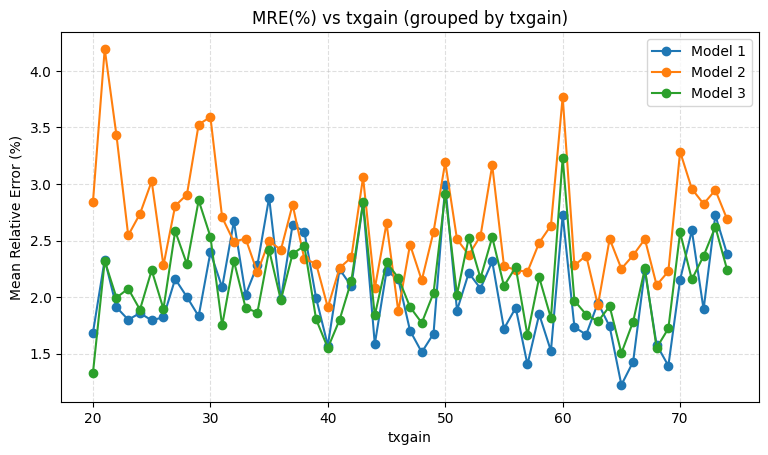

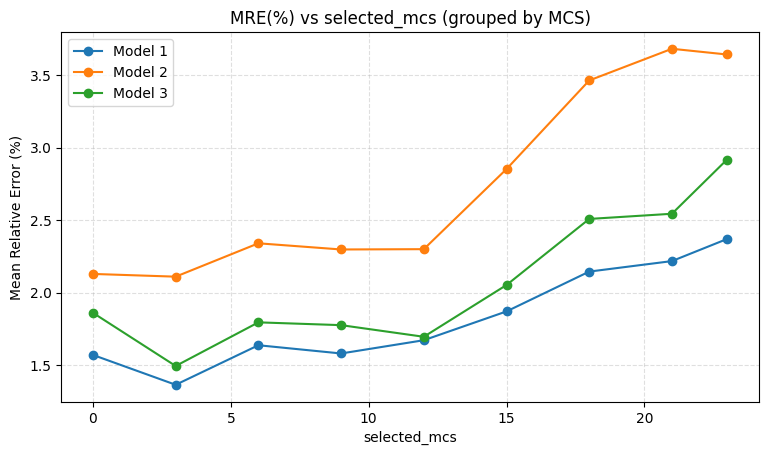

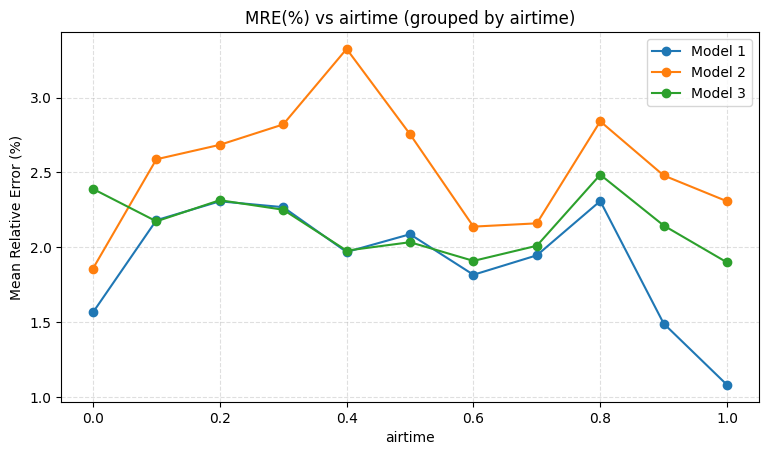

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 1) Row-wise relative error
# ------------------------------------------------------------
def row_relative_error(y_true, y_pred, eps=1e-9):
    """
    Per-sample relative error (not averaged yet).
    RE_i = |y_true - y_pred| / (|y_true| + eps)
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.abs(y_true - y_pred) / (np.abs(y_true) + eps)


# ------------------------------------------------------------
# 2) Build a unified test DataFrame for a given feature set
#    (raw y_true + predictions + xcol)
# ------------------------------------------------------------
def build_raw_test_df_for_mre(
    feat_name, xcol,
    test_outputs_m1, test_outputs_m2, test_outputs_m3
):
    """
    Create a DataFrame with columns:
      xcol, y_true, y_pred_m1, y_pred_m2, y_pred_m3
    """
    base = test_outputs_m1[feat_name]["test_df"].copy()

    df_plot = pd.DataFrame({
        xcol: base[xcol].values,
        "y_true": test_outputs_m1[feat_name]["y_true"],
        "y_pred_m1": test_outputs_m1[feat_name]["y_pred_m1"],
        "y_pred_m2": test_outputs_m2[feat_name]["y_pred_m2"],
        "y_pred_m3": test_outputs_m3[feat_name]["y_pred_m3"],
    })

    df_plot = df_plot.dropna().copy()
    return df_plot


# ------------------------------------------------------------
# 3) Compute MRE(%) grouped by xcol
# ------------------------------------------------------------
def compute_group_mre_curves(df_plot, xcol):
    """
    For each unique x value:
      - compute mean relative error (%) for each model
    Returns a DataFrame:
      xcol, mre_m1, mre_m2, mre_m3
    """
    d = df_plot.copy()

    # Per-sample relative errors
    d["re_m1"] = row_relative_error(d["y_true"], d["y_pred_m1"])
    d["re_m2"] = row_relative_error(d["y_true"], d["y_pred_m2"])
    d["re_m3"] = row_relative_error(d["y_true"], d["y_pred_m3"])

    # Group by x and take mean relative error within each x bin/value
    g = (
        d.groupby(xcol)[["re_m1", "re_m2", "re_m3"]]
        .mean()
        .reset_index()
        .sort_values(xcol)
        .rename(columns={
            "re_m1": "mre_m1",
            "re_m2": "mre_m2",
            "re_m3": "mre_m3",
        })
    )

    # Convert to percentage
    g["mre_m1"] *= 100
    g["mre_m2"] *= 100
    g["mre_m3"] *= 100

    return g


# ------------------------------------------------------------
# 4) Plot MRE curves (3 lines like your example)
# ------------------------------------------------------------
def plot_mre_curves(g, xcol, title):
    """
    Plot 3 MRE(%) curves: Model1/Model2/Model3
    """
    plt.figure(figsize=(9, 4.8))

    plt.plot(g[xcol], g["mre_m1"], marker="o", label="Model 1")
    plt.plot(g[xcol], g["mre_m2"], marker="o", label="Model 2")
    plt.plot(g[xcol], g["mre_m3"], marker="o", label="Model 3")

    plt.xlabel(xcol)
    plt.ylabel("Mean Relative Error (%)")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()


# ------------------------------------------------------------
# 5) Generate the 3 MRE plots (gain / mcs / airtime)
# ------------------------------------------------------------
MRE_PLOT_CONFIG = {
    "gain":   ("txgain", "MRE(%) vs txgain (grouped by txgain)"),
    "mcs":    ("selected_mcs", "MRE(%) vs selected_mcs (grouped by MCS)"),
    "airtime":("airtime", "MRE(%) vs airtime (grouped by airtime)"),
}

for feat_name, (xcol, title) in MRE_PLOT_CONFIG.items():
    df_plot = build_raw_test_df_for_mre(
        feat_name=feat_name,
        xcol=xcol,
        test_outputs_m1=test_outputs_m1,
        test_outputs_m2=test_outputs_m2,
        test_outputs_m3=test_outputs_m3
    )

    g = compute_group_mre_curves(df_plot, xcol=xcol)

    plot_mre_curves(g, xcol=xcol, title=title)


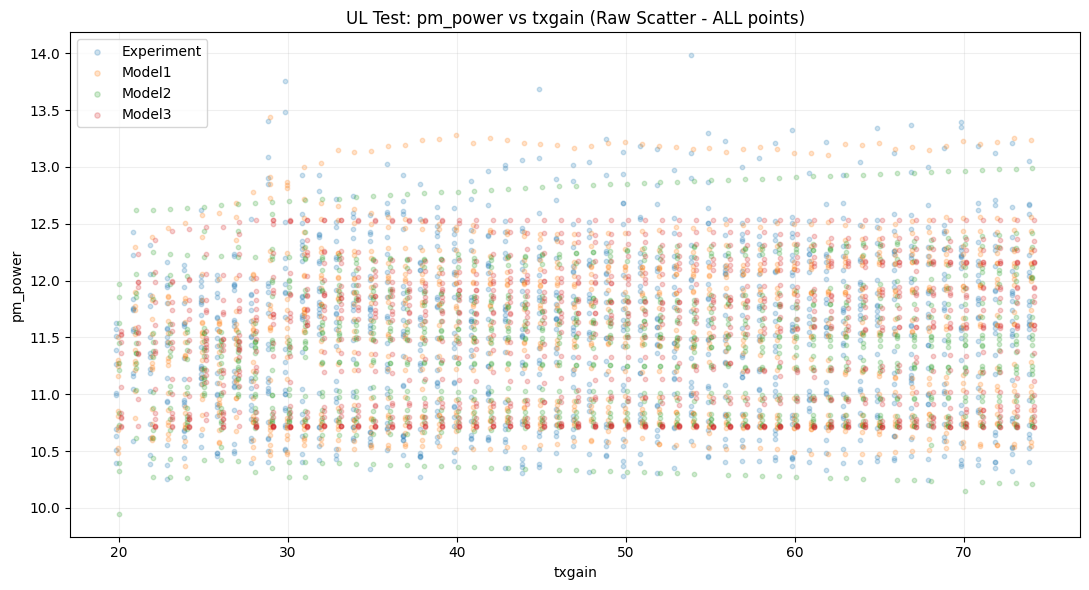

UL Test: pm_power vs txgain (Raw Scatter - ALL points)
Total points plotted (raw): 1158
[Model1] MSE=0.1026 RMSE=0.3203 MAE=0.2364 MRE=2.03%
[Model2] MSE=0.1628 RMSE=0.4035 MAE=0.3038 MRE=2.60%
[Model3] MSE=0.1142 RMSE=0.3380 MAE=0.2491 MRE=2.13%


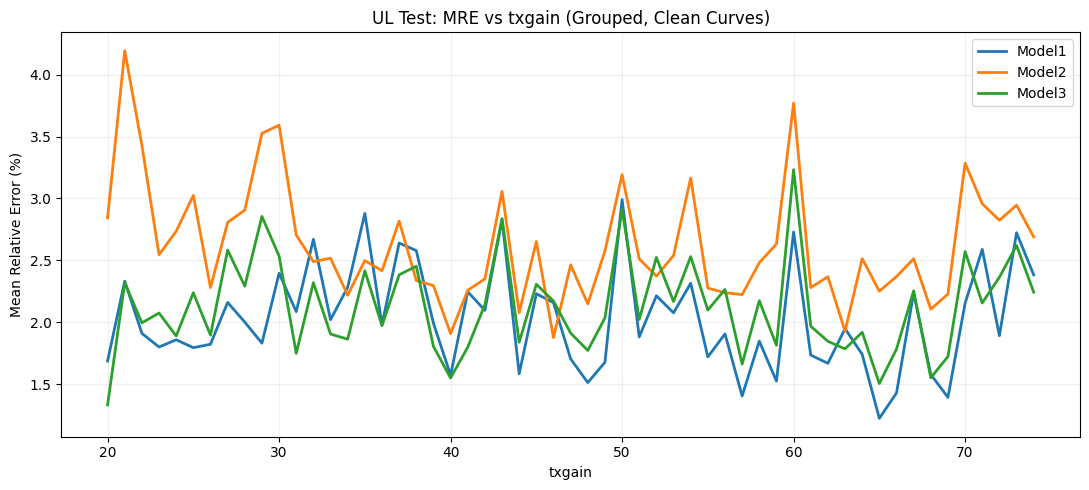

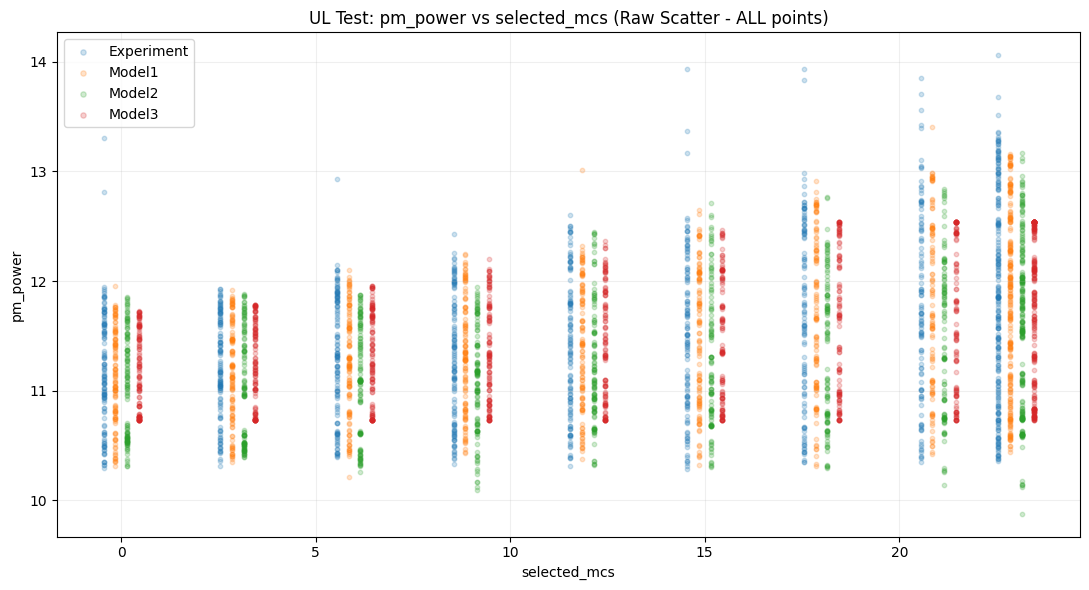

UL Test: pm_power vs selected_mcs (Raw Scatter - ALL points)
Total points plotted (raw): 1156
[Model1] MSE=0.0940 RMSE=0.3066 MAE=0.2167 MRE=1.87%
[Model2] MSE=0.2073 RMSE=0.4553 MAE=0.3322 MRE=2.82%
[Model3] MSE=0.1181 RMSE=0.3436 MAE=0.2493 MRE=2.14%


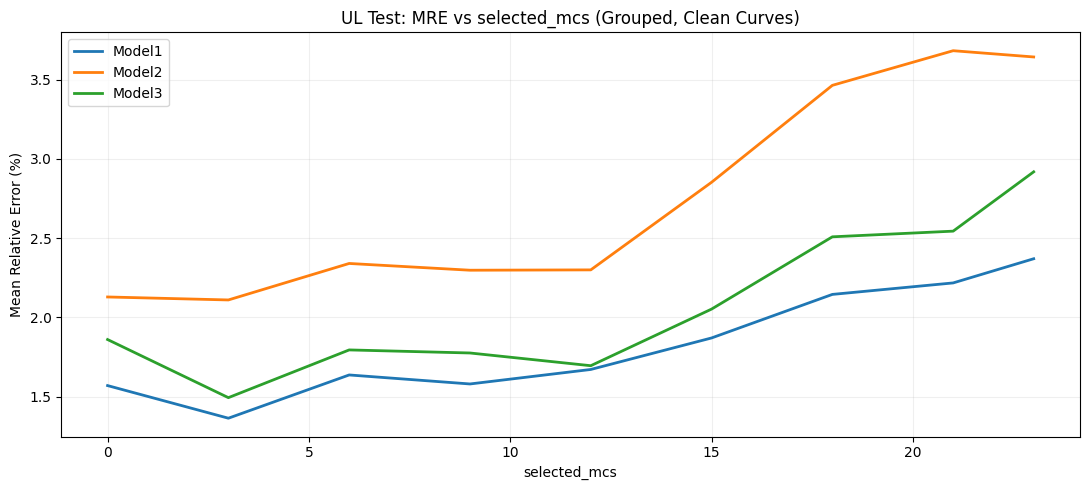

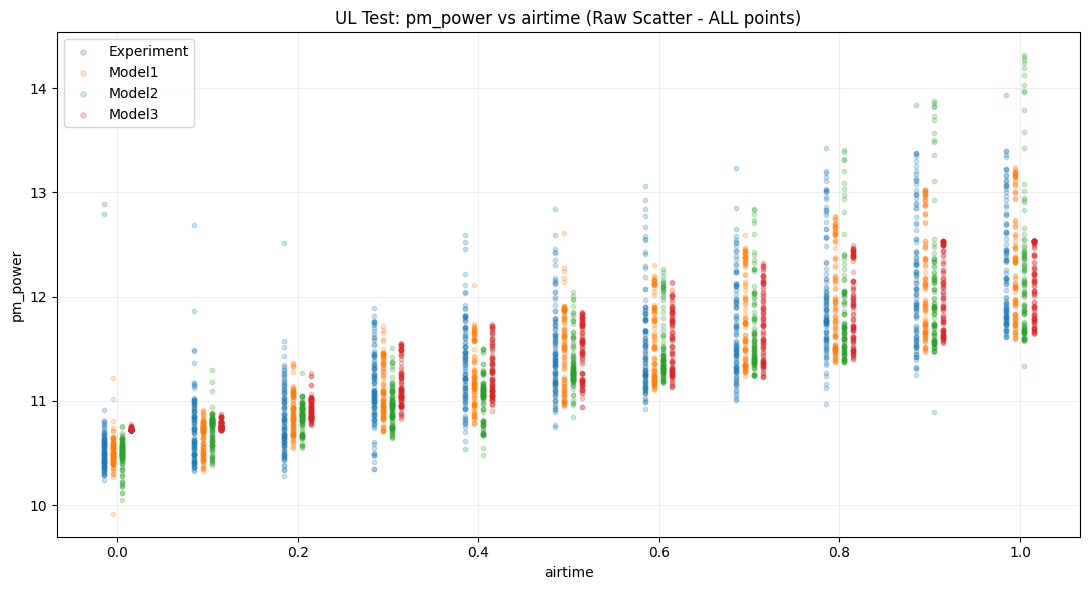

UL Test: pm_power vs airtime (Raw Scatter - ALL points)
Total points plotted (raw): 1159
[Model1] MSE=0.1013 RMSE=0.3183 MAE=0.2207 MRE=1.92%
[Model2] MSE=0.1819 RMSE=0.4265 MAE=0.2974 MRE=2.54%
[Model3] MSE=0.1198 RMSE=0.3461 MAE=0.2489 MRE=2.15%


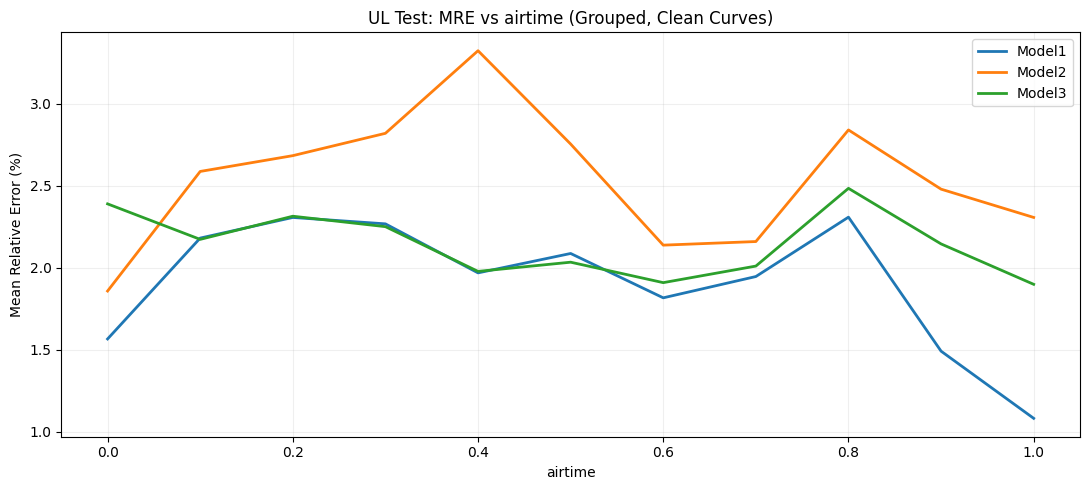

In [52]:
# ============================================================
# FULL RAW SCATTER (NO MEAN, NO SAMPLING) + CLEAN MRE CURVES
# Experiment + Model1 + Model2 + Model3
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------------------------------------------
# 1) Metric utilities
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return mse, rmse, mae, mre


# ------------------------------------------------------------
# 2) Build unified raw test DataFrame (NO averaging)
# ------------------------------------------------------------
def build_raw_test_dataframe(
    feat_name,
    xcol,
    test_outputs_m1,
    test_outputs_m2,
    test_outputs_m3
):
    """
    Construct a single DataFrame for plotting raw results.

    IMPORTANT:
    We assume y_true and predictions are aligned with test_df row order.
    """
    df_base = test_outputs_m1[feat_name]["test_df"].copy()

    df_plot = pd.DataFrame({
        xcol: df_base[xcol].values,
        "y_true":     np.asarray(test_outputs_m1[feat_name]["y_true"]).reshape(-1),
        "y_pred_m1":  np.asarray(test_outputs_m1[feat_name]["y_pred_m1"]).reshape(-1),
        "y_pred_m2":  np.asarray(test_outputs_m2[feat_name]["y_pred_m2"]).reshape(-1),
        "y_pred_m3":  np.asarray(test_outputs_m3[feat_name]["y_pred_m3"]).reshape(-1),
    })

    df_plot = df_plot.dropna().copy()
    return df_plot


# ------------------------------------------------------------
# 3) Full raw scatter plot (ALL points) with smart horizontal offset
# ------------------------------------------------------------
def plot_raw_scatter_with_offset_full(
    df_plot,
    xcol,
    title,
    offset_fraction=0.03,   # used for continuous x (e.g., airtime)
    point_size=10,           # smaller = cleaner
    alpha=0.25,             # lower = cleaner for dense plots
    figsize=(11, 6),
    rasterized=True         # good for saving to PDF (smaller file)
):
    """
    Plot raw scatter WITHOUT any mean aggregation AND WITHOUT sampling.
    For discrete x (txgain/mcs), offset based on median step.
    For continuous x (airtime), offset based on x-range fraction.
    """

    d = df_plot.dropna().copy()
    d = d.sort_values(xcol)

    x = d[xcol].to_numpy()
    x_unique = np.unique(x)
    unique_ratio = len(x_unique) / max(len(x), 1)

    # Decide offset scale
    if len(x_unique) <= 60 or unique_ratio < 0.02:
        # likely discrete (txgain/mcs)
        if len(x_unique) > 1:
            steps = np.diff(np.sort(x_unique))
            steps = steps[steps > 0]
            step = float(np.median(steps)) if len(steps) else 1.0
        else:
            step = 1.0
        dx = 0.1 * step
    else:
        # likely continuous (airtime)
        x_min, x_max = float(np.min(x)), float(np.max(x))
        x_range = max(x_max - x_min, 1e-9)
        dx = offset_fraction * x_range

    offsets = {"exp": -1.5 * dx, "m1": -0.5 * dx, "m2": 0.5 * dx, "m3": 1.5 * dx}

    # Metrics (ALL points)
    m1 = compute_metrics(d["y_true"], d["y_pred_m1"])
    m2 = compute_metrics(d["y_true"], d["y_pred_m2"])
    m3 = compute_metrics(d["y_true"], d["y_pred_m3"])

    # Plot
    plt.figure(figsize=figsize)

    plt.scatter(x + offsets["exp"], d["y_true"],    s=point_size, alpha=alpha, label="Experiment")
    plt.scatter(x + offsets["m1"],  d["y_pred_m1"], s=point_size, alpha=alpha, label="Model1")
    plt.scatter(x + offsets["m2"],  d["y_pred_m2"], s=point_size, alpha=alpha, label="Model2")
    plt.scatter(x + offsets["m3"],  d["y_pred_m3"], s=point_size, alpha=alpha, label="Model3")

    plt.xlabel(xcol)
    plt.ylabel("pm_power")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend(markerscale=1.2, frameon=True)
    plt.tight_layout()
    plt.show()

    # Print metrics
    print("=" * 60)
    print(title)
    print(f"Total points plotted (raw): {len(d)}")
    print(f"[Model1] MSE={m1[0]:.4f} RMSE={m1[1]:.4f} MAE={m1[2]:.4f} MRE={m1[3]:.2f}%")
    print(f"[Model2] MSE={m2[0]:.4f} RMSE={m2[1]:.4f} MAE={m2[2]:.4f} MRE={m2[3]:.2f}%")
    print(f"[Model3] MSE={m3[0]:.4f} RMSE={m3[1]:.4f} MAE={m3[2]:.4f} MRE={m3[3]:.2f}%")
    print("=" * 60)


# ------------------------------------------------------------
# 4) Clean MRE curve (grouped by x, NO errorbar, NO sampling)
# ------------------------------------------------------------
def group_mean_mre_curve(df_plot, xcol, pred_col, eps=1e-9, min_count=1):
    """
    Returns a DataFrame with columns: xcol, mre
    mre is the mean relative error (%) per x group.
    min_count can hide x-groups with too few samples.
    """
    d = df_plot[[xcol, "y_true", pred_col]].dropna().copy()
    d["rel_err"] = (np.abs(d["y_true"] - d[pred_col]) / (np.abs(d["y_true"]) + eps)) * 100

    g = d.groupby(xcol).agg(
        mre=("rel_err", "mean"),
        n=("rel_err", "size")
    ).reset_index()

    g = g[g["n"] >= min_count].copy()
    g = g.sort_values(xcol)
    return g


def plot_mre_curves_clean(
    df_plot,
    xcol,
    title,
    min_count=1,
    figsize=(11, 5)
):
    """
    Plot 3 clean MRE curves for Model1/2/3.
    """
    g1 = group_mean_mre_curve(df_plot, xcol, "y_pred_m1", min_count=min_count)
    g2 = group_mean_mre_curve(df_plot, xcol, "y_pred_m2", min_count=min_count)
    g3 = group_mean_mre_curve(df_plot, xcol, "y_pred_m3", min_count=min_count)

    plt.figure(figsize=figsize)
    plt.plot(g1[xcol], g1["mre"], label="Model1", linewidth=2)
    plt.plot(g2[xcol], g2["mre"], label="Model2", linewidth=2)
    plt.plot(g3[xcol], g3["mre"], label="Model3", linewidth=2)

    plt.xlabel(xcol)
    plt.ylabel("Mean Relative Error (%)")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 5) Generate plots for gain / mcs / airtime
# ------------------------------------------------------------
PLOT_CONFIG = {
    "gain":    ("txgain",        "UL Test: pm_power vs txgain (Raw Scatter - ALL points)"),
    "mcs":     ("selected_mcs",  "UL Test: pm_power vs selected_mcs (Raw Scatter - ALL points)"),
    "airtime": ("airtime",       "UL Test: pm_power vs airtime (Raw Scatter - ALL points)"),
}

# NOTE:
# This assumes you already have:
#   test_outputs_m1, test_outputs_m2, test_outputs_m3
# in memory with keys:
#   test_outputs_mX[feat_name]["test_df"], ["y_true"], ["y_pred_mX"]

for feat_name, (xcol, title) in PLOT_CONFIG.items():
    df_plot = build_raw_test_dataframe(
        feat_name=feat_name,
        xcol=xcol,
        test_outputs_m1=test_outputs_m1,
        test_outputs_m2=test_outputs_m2,
        test_outputs_m3=test_outputs_m3
    )

    # 1) Raw scatter overlay (ALL points)
    plot_raw_scatter_with_offset_full(
        df_plot=df_plot,
        xcol=xcol,
        title=title,
        offset_fraction=0.02,
        point_size=10,
        alpha=0.22,
        figsize=(11, 6)
    )

    # 2) Clean MRE curves
    plot_mre_curves_clean(
        df_plot=df_plot,
        xcol=xcol,
        title=f"UL Test: MRE vs {xcol} (Grouped, Clean Curves)",
        min_count=1
    )
